In [1]:
import numpy as np
import random
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import scatter, mask_to_index, index_to_mask, to_networkx
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch import optim
from torch_scatter import scatter_sum, scatter_mean
import pickle
import matplotlib.pyplot as plt
import copy
#from tree_util import load_merged_h5_trees, split_dataloader, dataset_to_dataloader
#from model_tree import TreeGINConv, TreeRegressor, MLPAgg, DeepSet, train_eval_model, eval_and_plot, plot_train_val_loss
from torch.utils.data import Subset
import math
import os

import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Load data

In [3]:
trainset = torch.load("/mnt/home/thuang/ceph/playground/datasets/SAM_trees/SAM_tree_train.pt",
                      weights_only=False)

valset = torch.load("/mnt/home/thuang/ceph/playground/datasets/SAM_trees/SAM_tree_val.pt",
                    weights_only=False)
testset = torch.load("/mnt/home/thuang/ceph/playground/datasets/SAM_trees/SAM_tree_test.pt",
                     weights_only=False)

In [4]:
print(len(testset))

4900


### Visualize trees 

In [505]:
def plot_tree(data, threshold=math.log10(3e10), title=None):
    G = to_networkx(data, to_undirected=False)
    pos = graphviz_layout(G, prog="dot")
    fig, ax = plt.subplots(dpi=200)
    
    mask_main = torch.isin(data.node_halo_id.flatten(), torch.LongTensor(data.mask_main)) #NOTE: a halo id may appear > 1 if the halo splits
    node_indices = torch.nonzero(mask_main).flatten()

    node_colors = ["red" if n in node_indices else "skyblue" for n in G.nodes()]
    
    nx.draw(G, pos=pos, with_labels=False, arrows=True, arrowsize=1,
            ax=ax, node_color=node_colors, node_size=3)
    if title is not None:
        ax.set_title(title, fontsize=20)

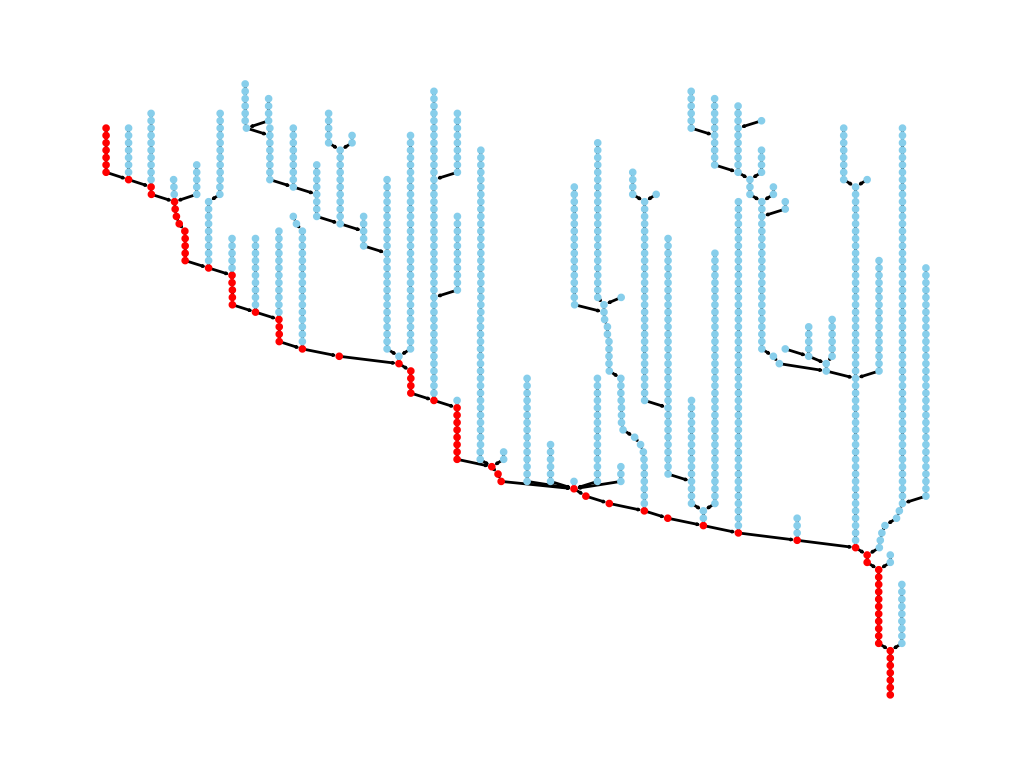

In [627]:
plot_tree(trainset[490])

# KS nearest neighbor

In [5]:
from scipy.stats import ks_2samp
from torch.utils.data import random_split

In [6]:
from joblib import Parallel, delayed

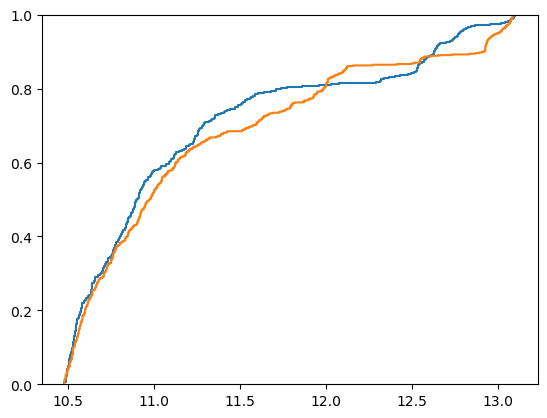

In [7]:
trainset[0].x[:,0]
plt.ecdf(trainset[0].x[:,0])
plt.ecdf(trainset[1].x[:,0])

In [8]:
sample1 = trainset[0].x[:,0]
sample2 = trainset[1].x[:,0]
result = ks_2samp(sample1, sample2)

In [9]:
result.statistic

0.08382526564344746

In [1811]:
train_size = len(trainset) # 4000
test_size =  len(testset)  #1000 

train_indices = np.random.choice(len(trainset), size=train_size, replace=False)
train_dataset = Subset(trainset, train_indices)

test_indices = np.random.choice(len(testset), size=test_size, replace=False)
test_dataset = Subset(testset, test_indices)

train_array = [data.x.cpu().numpy() for data in train_dataset]
test_array = [data.x.cpu().numpy() for data in test_dataset]


In [1812]:

def find_ks_neighbor(tree_index, n_train):
    ks_stats = np.full((n_train, 3), np.nan)

    def compute_ks(i, ks_stats):
        ks_stats[i,0] = ks_2samp(test_array[tree_index][:, 1], train_array[i][:, 1]).statistic
        ks_stats[i,1] = ks_2samp(test_array[tree_index][:, 2], train_array[i][:, 2]).statistic
        ks_stats[i,2] = ks_2samp(test_array[tree_index][:, 3], train_array[i][:, 3]).statistic

    Parallel(n_jobs=-1, backend='threading')(
        delayed(compute_ks)(i, ks_stats) for i in range(train_size)
    )

    return ks_stats



In [ ]:
# Test one one tree
kstats = find_ks_neighbor(0, len(train_array))


In [ ]:
# compute ks distances
n_tests = 1000
n_features = 3
ks_stats_all = np.full((n_tests, len(train_array), n_features), np.nan)
for i in range(n_tests):
    print(i)
    ks_stats_all[i,:,:] = find_ks_neighbor(i, len(train_array))


In [1816]:
ks_stats_all.shape

(1000, 4000, 3)

In [1817]:
omega_true = np.full(n_tests, np.nan)
sigma_true = np.full(n_tests, np.nan)

n_models = 4
omega_pred = np.full((n_tests, n_models), np.nan)
sigma_pred = np.full((n_tests, n_models), np.nan)

n_train_subset = 1000
ks_stats_sum = np.square(ks_stats_all[:,:n_train_subset,0]) + np.square(ks_stats_all[:,:n_train_subset,1]) + np.square(ks_stats_all[:,:n_train_subset,2])

for i in range(n_tests):
    omega_true[i], sigma_true[i] = test_dataset[i].y[0]
    omega_pred[i,0], sigma_pred[i,0] = train_dataset[np.argmin(ks_stats_all[i,:n_train_subset,0])].y[0]
    omega_pred[i,1], sigma_pred[i,1] = train_dataset[np.argmin(ks_stats_all[i,:n_train_subset,1])].y[0]
    omega_pred[i,2], sigma_pred[i,2] = train_dataset[np.argmin(ks_stats_all[i,:n_train_subset,2])].y[0]
    omega_pred[i,3], sigma_pred[i,3] = train_dataset[np.argmin(ks_stats_sum[i,:])].y[0]


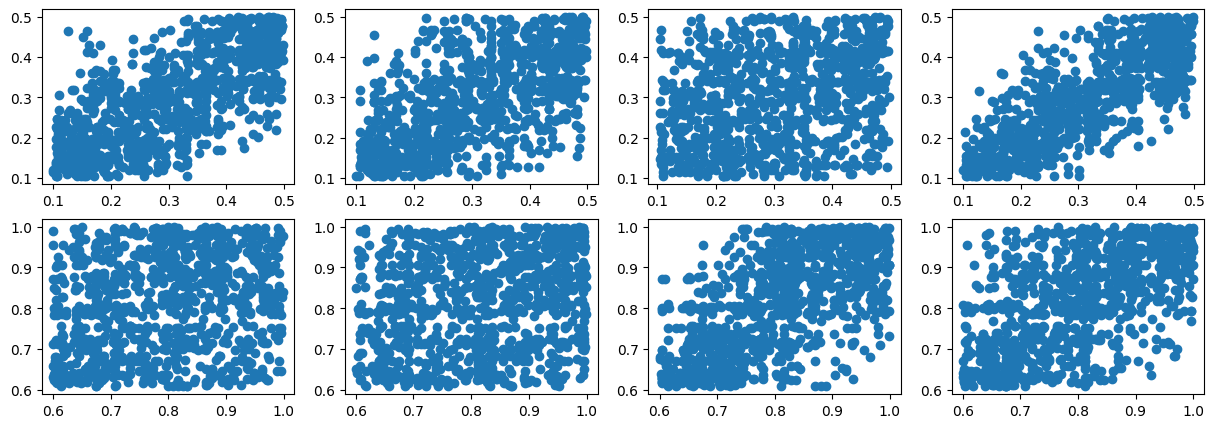

In [1818]:
fig, ax = plt.subplots(2, 4, figsize = (15, 5))

up_i = 1499

for j in range(n_models):
    ax[0, j].scatter(omega_pred[:up_i, j], omega_true[:up_i])
    ax[1, j].scatter(sigma_pred[:up_i, j], sigma_true[:up_i])

In [1819]:
# compute R2
R2 = np.full((2, 4), np.nan)
se = np.full((2, 4, n_tests), np.nan)

for i in range(4):
    se[0, i] = (omega_pred[:,i] - omega_true)**2
    se[1, i] = (sigma_pred[:,i] - sigma_true)**2

    R2[0, i] = 1 - np.mean(se[0, i]) / np.var(omega_true)
    R2[1, i] = 1 - np.mean(se[1, i]) / np.var(sigma_true)


In [1820]:
print(R2)

[[ 0.40048861  0.20442447 -0.4046672   0.59089595]
 [-0.55776569 -0.54041673  0.31831209  0.21047118]]


In [1800]:
# report bootstrap intervals for most expressive models
n_bootstraps = 100
R2_bootstrap = np.full((2, n_bootstraps), np.nan)

for i in range(n_bootstraps):
    mse_omega_sample = np.random.choice(se[0, 3, :], size=n_bootstraps, replace=True)
    mse_sigma_sample = np.random.choice(se[1, 3, :], size=n_bootstraps, replace=True)
    R2_bootstrap[0, i] = 1 - np.mean(mse_omega_sample) / np.var(omega_true)
    R2_bootstrap[1, i] = 1 - np.mean(mse_sigma_sample) / np.var(sigma_true)


In [1801]:
print(np.std(R2_bootstrap[0,:]))
print(np.std(R2_bootstrap[1,:]))

0.06315637675241957
0.11239855948742139


In [1778]:
omega_train = np.full(len(train_array), np.nan)
sigma_train = np.full(len(train_array), np.nan)

for i in range(len(train_array)):
    omega_train[i], sigma_train[i] = train_dataset[i].y[0]

In [1779]:
sigma_train

array([0.92299998, 0.82980001, 0.85500002, ..., 0.99739999, 0.90060002,
       0.9102    ], shape=(2000,))

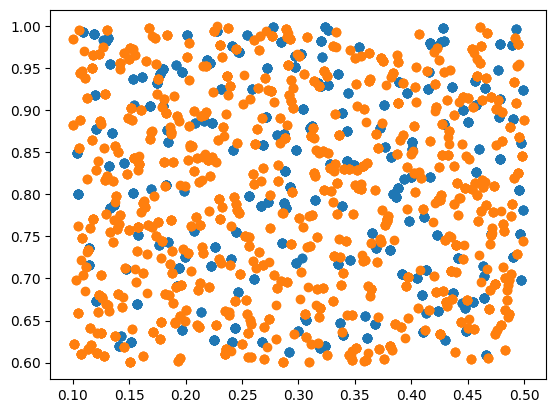

In [1780]:
# scatter plot of all the densities
plt.scatter(omega_true, sigma_true)
plt.scatter(omega_train, sigma_train)

In [1807]:
# save trained distances
np.save('deliv/ks_stats_all.npy' ,ks_stats_all)